### Sensor Constants

In [28]:
M = 28.01
sensor_name = 'alpha_co_conc'
sampling_period = 15 * 60

## Upload Data from File

In [29]:
import pandas as pd

directory_path = 'input/'
file_name = sensor_name + 'dataframe_no_changepoint.csv'
df = pd.read_csv(directory_path + file_name)
df.head()

,DateTime,measuring,value
0,2022-11-27 14:15:00,119.370,0.136751
1,2022-11-27 14:30:00,111.245,0.127443
2,2022-11-27 14:45:00,108.655,0.124476
3,2022-11-27 17:00:00,100.800,0.115477
4,2022-11-27 17:15:00,96.945,0.111061


### Create Sensor Dataframe as Pandas Series with a period of 15 mins

In [30]:
# Remove the first column with the indexes and save data into web dataframe
dataframe = df.drop(df.columns[0], axis='columns')
dataframe['DateTime'] = (pd.to_datetime(df['DateTime'], infer_datetime_format=True))

# Resample data with 15 mins period and create sensor dataframe
sensor_dataframe = dataframe.sort_values(by='DateTime', ascending=True).reset_index().drop(columns='index')
sensor_dataframe.index = sensor_dataframe['DateTime']
sensor_dataframe = sensor_dataframe.drop(columns=['DateTime'])
sensor_dataframe = sensor_dataframe.resample('15T').mean()
sensor_dataframe.head()

/var/folders/wc/_83zcrx913j1dqwg4g90kbhh0000gp/T/ipykernel_56380/828121487.py:3: UserWarning: The argument 'infer_datetime_format' is deprecated and will be removed in a future version. A strict version of it is now the default, see https://pandas.pydata.org/pdeps/0004-consistent-to-datetime-parsing.html. You can safely remove this argument.
  dataframe['DateTime'] = (pd.to_datetime(df['DateTime'], infer_datetime_format=True))


,measuring,value
DateTime,,
2022-11-27 14:15:00,119.370,0.136751
2022-11-27 14:30:00,111.245,0.127443
2022-11-27 14:45:00,108.655,0.124476
2022-11-27 15:00:00,NaN,NaN
2022-11-27 15:15:00,NaN,NaN


### Plot raw data

<Axes: xlabel='DateTime'>

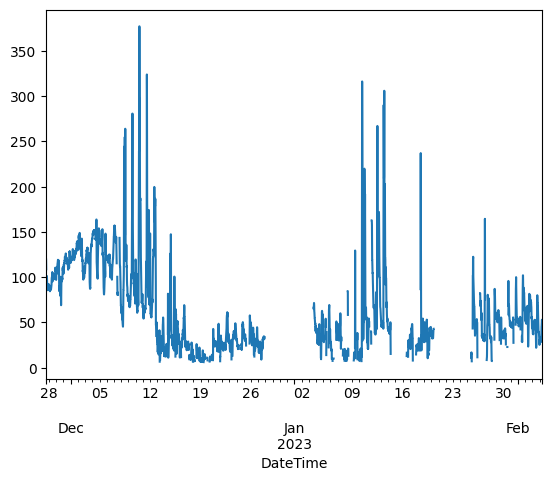

In [31]:
sensor_dataframe['measuring'].plot()

## Analyse valid data

The graph shows the time series of the valid data, box plots of the data grouped by hour of the day, and histogram of the data.

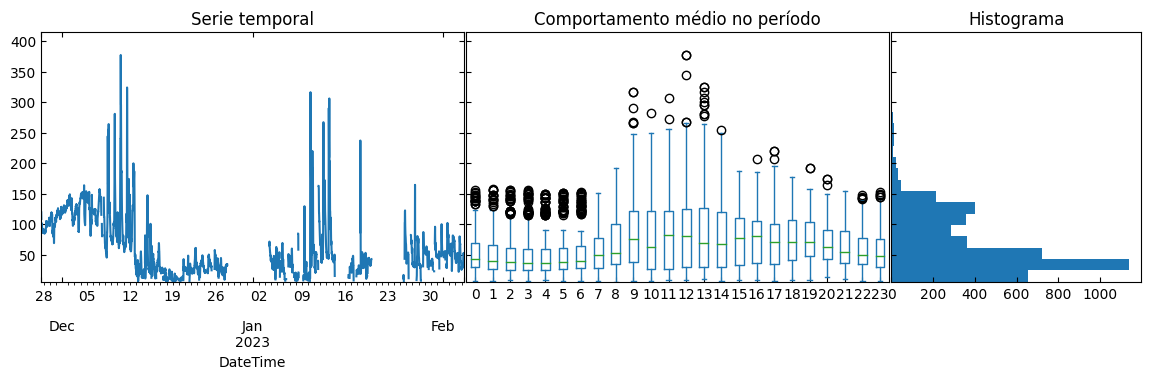

In [32]:
from SensorDataAnalysisService import SensorDataAnalysisService as sensor_analysis

sensor_dataframe['Hour'] = sensor_dataframe.index.hour
sensor_analysis.plot_box_hist(df=sensor_dataframe, bins=20)

### Apply log transformation to normalize data

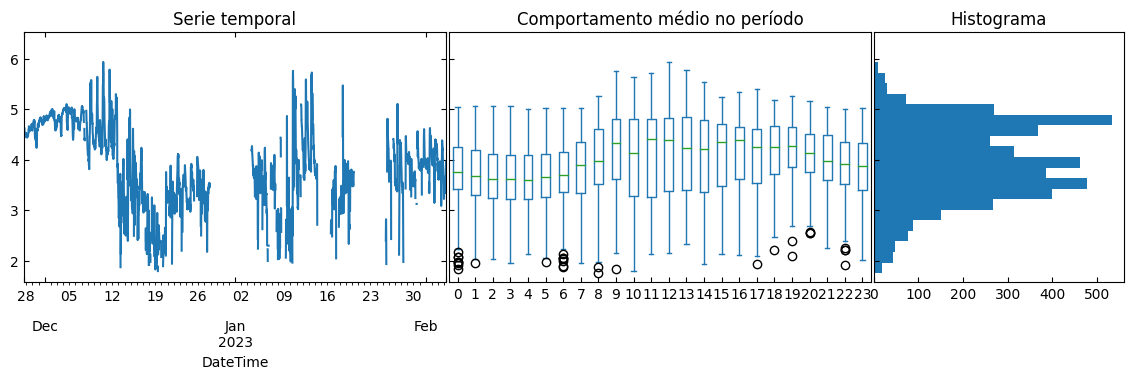

In [33]:
import numpy as np

sensor_dataframe['original measuring'] = sensor_dataframe['measuring']
sensor_dataframe['measuring'] = sensor_dataframe['original measuring'].apply(lambda m: np.log(m))
sensor_analysis.plot_box_hist(df=sensor_dataframe, bins=20)

### Box plots by months

<Axes: title={'center': 'Comportamento médio no período'}>

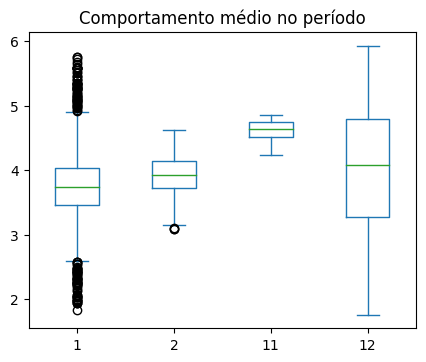

In [34]:
import matplotlib.pylab as plt

sensor_dataframe['Month'] = sensor_dataframe.index.month

df = sensor_dataframe
df = df.dropna(axis='index', how='all', subset=['Month'])
df['Month'] = df['Month'].astype('int64')
plt.figure(figsize=(5, 5/1.3))
ax_box  = plt.axes()
df.pivot(columns='Month')['measuring'].dropna(
        axis='columns', how='all').plot.box(
            ax=ax_box,title='Comportamento médio no período')

### Calculate quantiles

We calculated the 1% and 99 % quantiles of every hour of the day. The values greater outside the 1 % - 99 % where tagged as Greater that Quantile 99 (GTQTLE99) and Lower than Quantile 1 (LTQTLE01)

<Axes: xlabel='DateTime'>

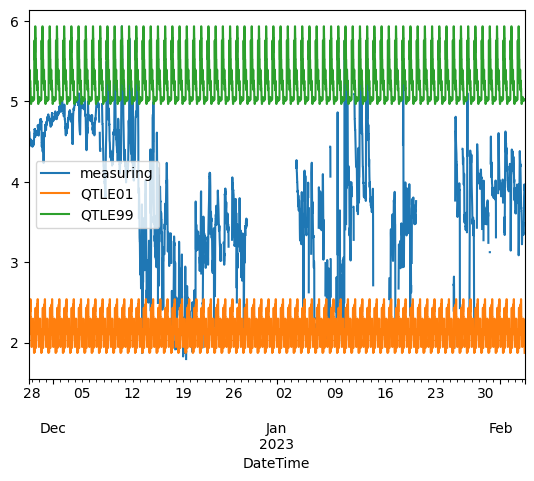

In [35]:
import numpy as np

global_qtle_01 = sensor_dataframe.pivot(columns='Hour')['measuring'].quantile(q=0.01, axis='index', interpolation='lower').dropna()
global_qtle_99 = sensor_dataframe.pivot(columns='Hour')['measuring'].quantile(q=0.99, axis='index', interpolation='higher').dropna()
sensor_dataframe['QTLE01'] = sensor_dataframe['Hour'].map(lambda hr: global_qtle_01[hr] if (not np.isnan(hr)) else np.nan)
sensor_dataframe['QTLE99'] = sensor_dataframe['Hour'].map(lambda hr: global_qtle_99[hr] if (not np.isnan(hr)) else np.nan)
sensor_dataframe[['measuring', 'QTLE01', 'QTLE99']].resample('15T').mean().plot()

## Tag data
Apply tags to the data according to the quality control processes described above

In [36]:
sensor_dataframe['Tag'] = 'VALID'

### Tag data according to quantiles

In [37]:
sensor_dataframe['Tag'] = (sensor_dataframe[['Tag', 'measuring', 'QTLE01', 'QTLE99']]
                           .apply(lambda df: sensor_analysis.tag_by_quantiles(current_tag=df[0],
                                                                              value=df[1],
                                                                              quantile_01=df[2],
                                                                              quantile_99=df[3]),
                                axis=1))
tags = ['VALID', 'LTQTLE01', 'GTQTLE99']
data_contabilization = sensor_analysis.count_tags(tags, sensor_dataframe)
data_contabilization

,#,%
VALID,6478,98.136646
LTQTLE01,61,0.924102
GTQTLE99,62,0.939252
TOTAL,6601,100.0


#### Plot valid data

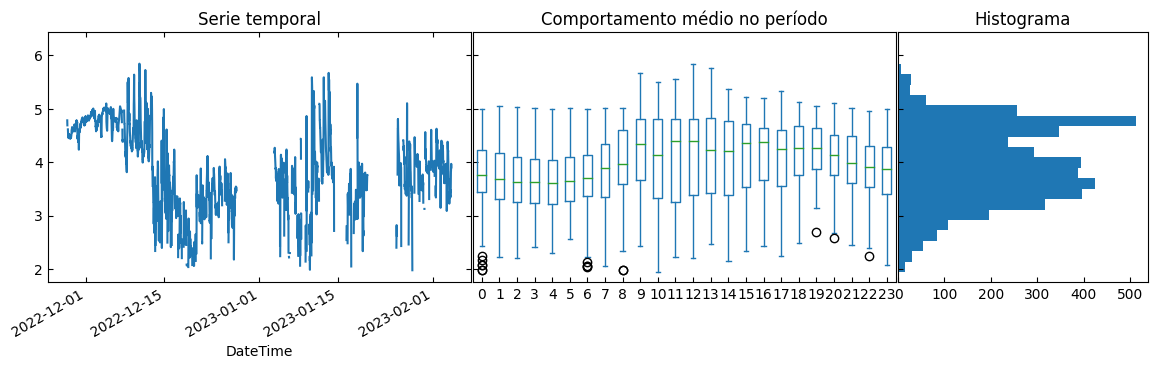

In [38]:
df = sensor_dataframe[sensor_dataframe['Tag'] == 'VALID']
sensor_analysis.plot_box_hist(df=df, bins=20)

## Resample valid data to 1 HR

<Axes: xlabel='DateTime'>

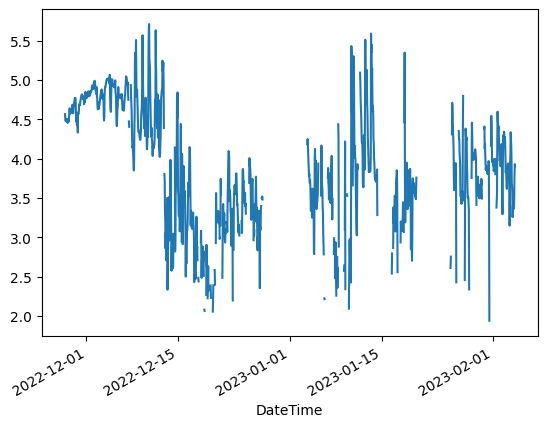

In [39]:
valid_dataframe = sensor_dataframe[sensor_dataframe['Tag'] == 'VALID']
resampled_dataframe = sensor_dataframe[sensor_dataframe['Tag'] == 'VALID'].drop(columns=['Tag']).resample('H').mean()
resampled_dataframe['Hour'] = resampled_dataframe.index.hour
resampled_dataframe['Count'] = (valid_dataframe['measuring'].resample('H').count())
resampled_dataframe['Std'] = (valid_dataframe['measuring'].resample('H').std())
resampled_dataframe.index = resampled_dataframe.index.map(lambda t: t.replace(minute=30, second=0))
resampled_dataframe['measuring'].plot()

#### Tag hourly data according to the number of samples in an hour
At least 3 samples must be valid in an hour (75 %) for the hourly data be considered as valid

<Axes: xlabel='DateTime'>

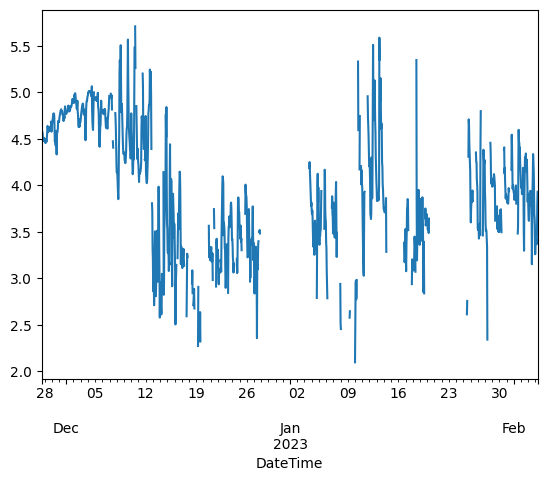

In [40]:
original_freq = sensor_dataframe.index.freq
resampled_dataframe['% valid'] = (resampled_dataframe['Count']
                                    .map(lambda c:
                                        c / (pd.Timedelta("1 hour") / original_freq) * 100))
resampled_dataframe['Tag'] = (resampled_dataframe['% valid']
                                .map(lambda c: 'VALID' if c >= 75 else 'LOWSAMPLES'))
resampled_dataframe[resampled_dataframe['Tag'] == 'VALID']['measuring'].resample('H').mean().plot()

#### Valid data contabilization

In [41]:
tags = ['LOWSAMPLES','VALID'] 
data_contabilization = sensor_analysis.count_tags(tags, resampled_dataframe)
data_contabilization

,#,%
LOWSAMPLES,634,38.400969
VALID,1017,61.599031
TOTAL,1651,100.0


## Analyse the mean and standard deviation of the resampled data

The color of each data point represents the percentage of valid 15 mins samples found in an hour

#### Plot mean (Y axis) vs. standard deviation (X axis) for valid hourly data colored by valid percentage of valid samples

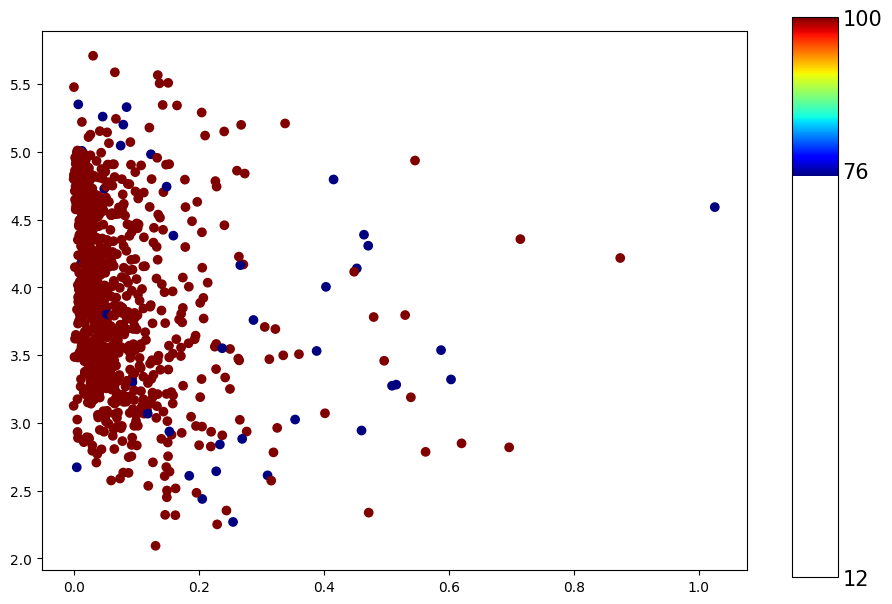

In [42]:
valid_resampled_dataframe = resampled_dataframe[resampled_dataframe['Tag'] == 'VALID']
sensor_analysis.plot_mean_vs_std(valid_resampled_dataframe)

### Plot standard deviation in time colored according to the percentage of valid samples

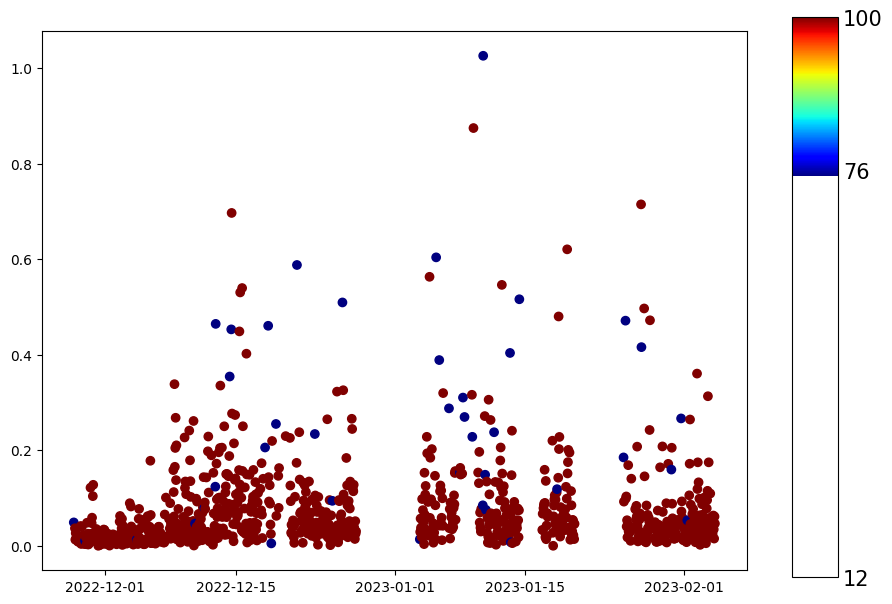

In [43]:
sensor_analysis.plot_std_in_time(valid_resampled_dataframe)

## Decompose signal

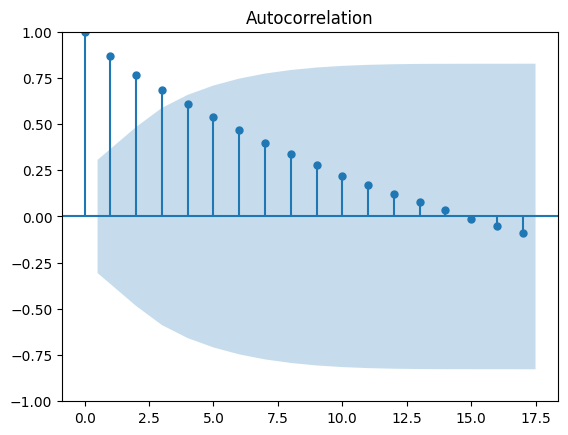

<Figure size 910x700 with 0 Axes>

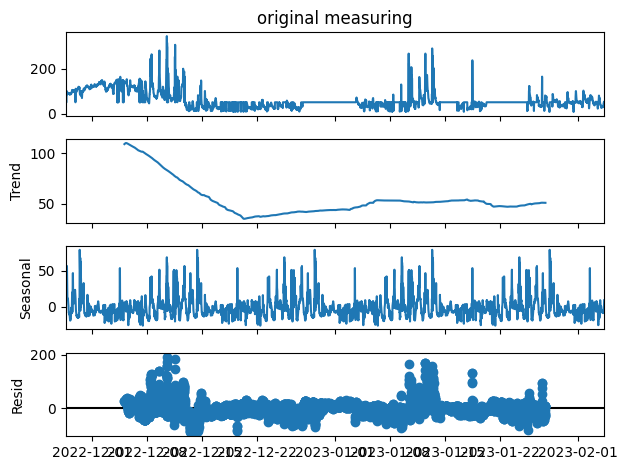

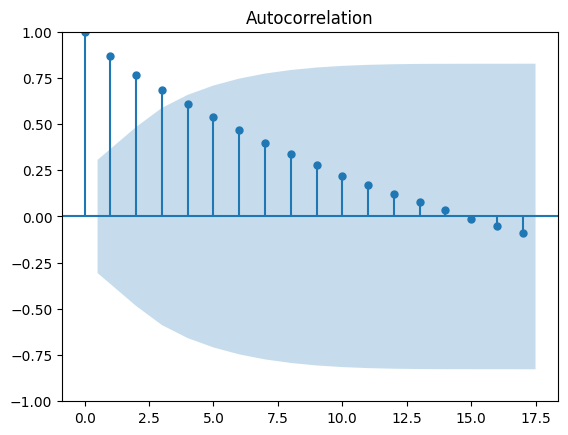

In [44]:
from statsmodels.tsa import stattools
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.graphics import tsaplots

fill_value = valid_dataframe['original measuring'].median()
signal = seasonal_decompose(valid_dataframe['original measuring'].resample('15T').mean().fillna(value=fill_value),
                                      model='additive', period=15*4*24)
plt.figure(figsize=(1.3*7,7))
signal.plot()
tsaplots.plot_acf(stattools.acf(signal.resid.dropna(), nlags=40, fft=False))

<Axes: >

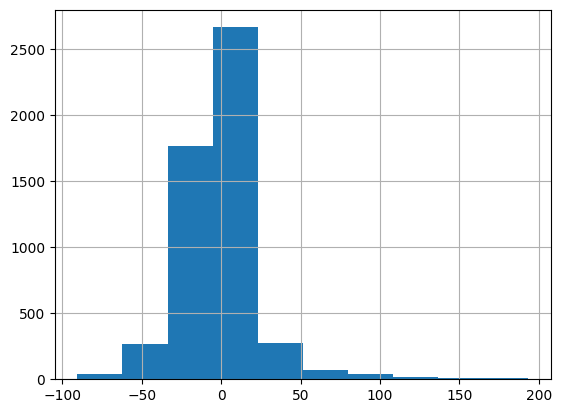

In [45]:
signal.resid.hist()

In [46]:
valid_resampled_dataframe['trend'] = signal.trend

/var/folders/wc/_83zcrx913j1dqwg4g90kbhh0000gp/T/ipykernel_56380/2319109946.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  valid_resampled_dataframe['trend'] = signal.trend


## Compare with original data

In [47]:
input_data_directory = 'input/'
reference_data_path = input_data_directory + 'ref_air_quality_data_Vila_Moema.csv'
reference_column_name = 'Monóxido de Carbono'

## Load reference and sensor data

In [48]:
import pandas as pd

reference_data = pd.read_csv(reference_data_path)
reference_data['DateTime'] = (pd.to_datetime(reference_data['DateTime'], infer_datetime_format=True))
reference_data = reference_data.sort_values(by='DateTime', ascending=True).reset_index().drop(columns='index')
reference_data.index = reference_data['DateTime']
reference_data = reference_data.drop(columns='DateTime')[reference_column_name]

sensor_data = valid_resampled_dataframe
reference_data.head()

/var/folders/wc/_83zcrx913j1dqwg4g90kbhh0000gp/T/ipykernel_56380/1855377823.py:4: UserWarning: The argument 'infer_datetime_format' is deprecated and will be removed in a future version. A strict version of it is now the default, see https://pandas.pydata.org/pdeps/0004-consistent-to-datetime-parsing.html. You can safely remove this argument.
  reference_data['DateTime'] = (pd.to_datetime(reference_data['DateTime'], infer_datetime_format=True))


DateTime
2022-01-01 02:30:00    0.1467
2022-01-01 03:30:00    0.1544
2022-01-01 04:30:00    0.1167
2022-01-01 05:30:00    0.1079
2022-01-01 06:30:00    0.1154
Name: Monóxido de Carbono, dtype: float64

### Select period of interest according to CO sensor data

In [49]:
reference_data = reference_data[reference_data.index >= valid_resampled_dataframe.index[0]]
reference_data = reference_data[reference_data.index <= valid_resampled_dataframe.index[-1]]
reference_data

DateTime
2022-11-27 14:30:00    0.0013
2022-11-27 15:30:00    0.0050
2022-11-27 16:30:00    0.0121
2022-11-27 17:30:00    0.0011
2022-11-27 18:30:00    0.0095
                        ...  
2023-02-04 03:30:00    0.1174
2023-02-04 04:30:00    0.1153
2023-02-04 05:30:00    0.1395
2023-02-04 06:30:00    0.1864
2023-02-04 07:30:00    0.1965
Name: Monóxido de Carbono, Length: 1650, dtype: float64

## Append reference column to CO sensor Data

In [50]:
sensor_data['reference'] = reference_data
sensor_data

/var/folders/wc/_83zcrx913j1dqwg4g90kbhh0000gp/T/ipykernel_56380/2909827499.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sensor_data['reference'] = reference_data


,measuring,value,Hour,original measuring,Month,QTLE01,QTLE99,Count,Std,% valid,Tag,trend,reference
DateTime,,,,,,,,,,,,,
2022-11-27 14:30:00,4.727380,0.129557,14,113.09000,11.0,1.932970,5.519599,3,0.048938,75.0,VALID,NaN,0.0013
2022-11-27 17:30:00,4.565170,0.110125,17,96.12750,11.0,2.102303,5.392832,4,0.036613,100.0,VALID,NaN,0.0011
2022-11-27 18:30:00,4.514883,0.104677,18,91.37250,11.0,2.473171,5.138237,4,0.012771,100.0,VALID,NaN,0.0095
2022-11-27 19:30:00,4.479458,0.101054,19,88.21000,11.0,2.383243,5.256792,4,0.026463,100.0,VALID,NaN,0.0178
2022-11-27 20:30:00,4.475651,0.100650,20,87.85750,11.0,2.538842,5.159630,4,0.013193,100.0,VALID,NaN,0.0133
...,...,...,...,...,...,...,...,...,...,...,...,...,...
2023-02-04 03:30:00,3.413960,0.034862,3,30.43125,2.0,2.081315,5.023025,4,0.063328,100.0,VALID,NaN,0.1174
2023-02-04 04:30:00,3.364650,0.033150,4,28.93625,2.0,2.296567,5.002368,4,0.034316,100.0,VALID,NaN,0.1153
2023-02-04 05:30:00,3.504082,0.038096,5,33.25375,2.0,2.125848,5.017081,4,0.015069,100.0,VALID,NaN,0.1395


### Plot reference and sensor data

<Axes: xlabel='DateTime'>

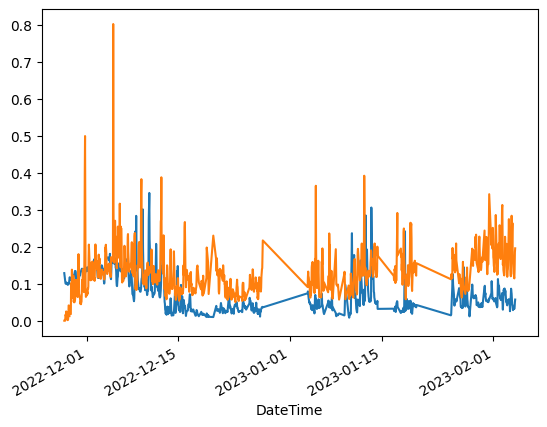

In [51]:
sensor_data['value'].plot()
sensor_data['reference'].plot()

## Separate reference data and valid sensor data

In [52]:
data = sensor_data[sensor_data.index <= reference_data.index[-1]][['value', 'reference', 'trend']]
data

,value,reference,trend
DateTime,,,
2022-11-27 14:30:00,0.129557,0.0013,NaN
2022-11-27 17:30:00,0.110125,0.0011,NaN
2022-11-27 18:30:00,0.104677,0.0095,NaN
2022-11-27 19:30:00,0.101054,0.0178,NaN
2022-11-27 20:30:00,0.100650,0.0133,NaN
...,...,...,...
2023-02-04 03:30:00,0.034862,0.1174,NaN
2023-02-04 04:30:00,0.033150,0.1153,NaN
2023-02-04 05:30:00,0.038096,0.1395,NaN


## Plot sensor vs. reference

Spearmans correlation coefficient: 0.290
Samples are correlated (reject H0) p=0.000
Kendall correlation coefficient: 0.290
Samples are correlated (reject H0) p=0.000


Text(0.05, 0.9, "Kendall's tau=0.196, p<0.05")

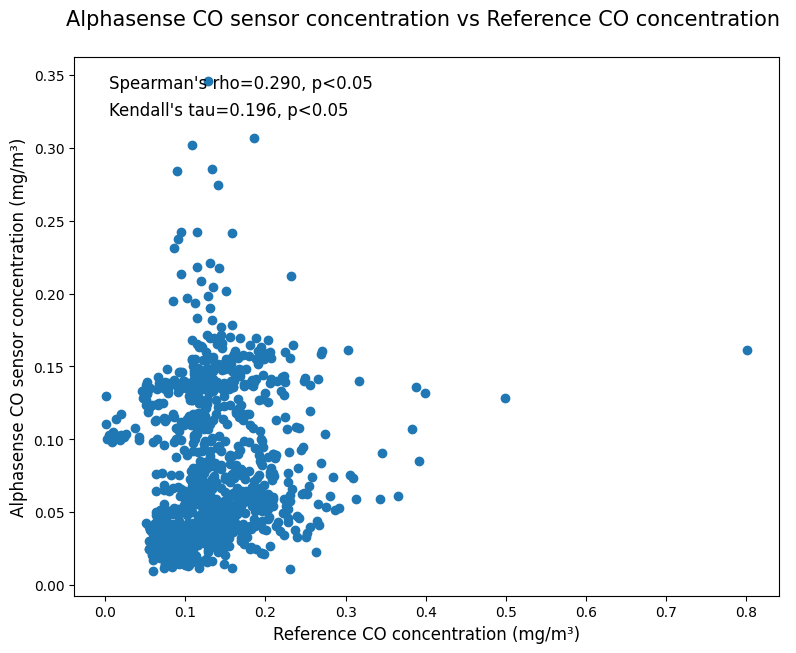

In [53]:
from scipy.stats import spearmanr
from scipy.stats import kendalltau
import matplotlib.pyplot as plt

fig, ax = plt.subplots(figsize=(1.3*7,7))

plt.scatter(data['reference'], data['value'])
plt.title('Alphasense CO sensor concentration vs Reference CO concentration \n', 
          fontdict={'fontsize':15})
plt.xlabel('Reference CO concentration (mg/m\N{SUPERSCRIPT THREE})', 
           fontsize=12)
plt.ylabel('Alphasense CO sensor concentration (mg/m\N{SUPERSCRIPT THREE})', 
           fontsize=12)
coef, p = spearmanr(data['reference'], data['value'], 
                    nan_policy='omit')
print('Spearmans correlation coefficient: %.3f' % coef)
# interpret the significance
alpha = 0.05
if p > alpha:
	print('Samples are uncorrelated (fail to reject H0) p=%.3f' % p)
else:
	print('Samples are correlated (reject H0) p=%.3f' % p)

kendall, pken = kendalltau( data['reference'], data['value'], 
                            nan_policy='omit')
print('Kendall correlation coefficient: %.3f' % coef)
# interpret the significance
alpha = 0.05
if p > alpha:
	print('Samples are uncorrelated (fail to reject H0) p=%.3f' % p)
else:
	print('Samples are correlated (reject H0) p=%.3f' % p)
 
string = 'Spearman\'s rho=%.3f, p<0.05' % coef
plt.text(0.05, 0.95, string, horizontalalignment='left', fontsize=12,
         verticalalignment='center', transform=ax.transAxes)
string = 'Kendall\'s tau=%.3f, p<0.05' % kendall
plt.text(0.05, 0.90, string, horizontalalignment='left', fontsize=12,
         verticalalignment='center', transform=ax.transAxes)

## Plot sensor trend vs. reference

Spearmans correlation coefficient: 0.392
Samples are correlated (reject H0) p=0.000
Kendall correlation coefficient: 0.392
Samples are correlated (reject H0) p=0.000


Text(0.05, 0.9, "Kendall's tau=0.272, p<0.05")

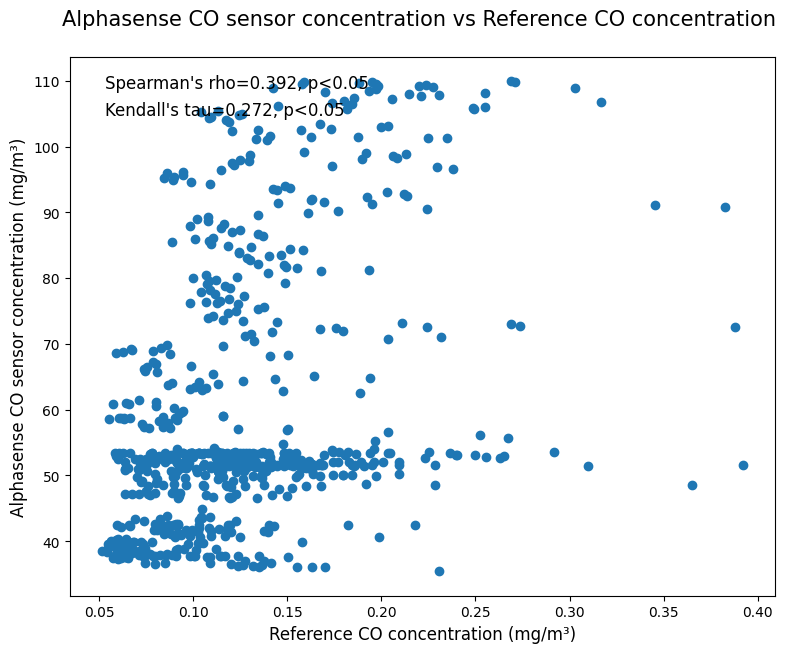

In [54]:
from scipy.stats import spearmanr
from scipy.stats import kendalltau
import matplotlib.pyplot as plt

fig, ax = plt.subplots(figsize=(1.3*7,7))

plt.scatter(data['reference'], data['trend'])
plt.title('Alphasense CO sensor concentration vs Reference CO concentration \n', 
          fontdict={'fontsize':15})
plt.xlabel('Reference CO concentration (mg/m\N{SUPERSCRIPT THREE})', 
           fontsize=12)
plt.ylabel('Alphasense CO sensor concentration (mg/m\N{SUPERSCRIPT THREE})', 
           fontsize=12)
coef, p = spearmanr(data['reference'], data['trend'], 
                    nan_policy='omit')
print('Spearmans correlation coefficient: %.3f' % coef)
# interpret the significance
alpha = 0.05
if p > alpha:
	print('Samples are uncorrelated (fail to reject H0) p=%.3f' % p)
else:
	print('Samples are correlated (reject H0) p=%.3f' % p)

kendall, pken = kendalltau( data['reference'], data['trend'], 
                            nan_policy='omit')
print('Kendall correlation coefficient: %.3f' % coef)
# interpret the significance
alpha = 0.05
if p > alpha:
	print('Samples are uncorrelated (fail to reject H0) p=%.3f' % p)
else:
	print('Samples are correlated (reject H0) p=%.3f' % p)
 
string = 'Spearman\'s rho=%.3f, p<0.05' % coef
plt.text(0.05, 0.95, string, horizontalalignment='left', fontsize=12,
         verticalalignment='center', transform=ax.transAxes)
string = 'Kendall\'s tau=%.3f, p<0.05' % kendall
plt.text(0.05, 0.90, string, horizontalalignment='left', fontsize=12,
         verticalalignment='center', transform=ax.transAxes)